## 1. American Sign Language (ASL)
<p>American Sign Language (ASL) is the primary language used by many deaf individuals in North America, and it is also used by hard-of-hearing and hearing individuals.  The language is as rich as spoken languages and employs signs made with the hand, along with facial gestures and bodily postures.</p>
<p><img src="https://assets.datacamp.com/production/project_509/img/asl.png" alt="american sign language"></p>
<p>A lot of recent progress has been made towards developing computer vision systems that translate sign language to spoken language.  This technology  often relies on complex neural network architectures that can detect subtle patterns in streaming video.  However, as a first step, towards understanding how to build a translation system, we can reduce the size of the problem by translating individual letters, instead of sentences.</p>
<p><strong>In this notebook</strong>, we will train a convolutional neural network to classify images of American Sign Language (ASL) letters.  After loading, examining, and preprocessing the data, we will train the network and test its performance.</p>
<p>In the code cell below, we load the training and test data. </p>
<ul>
<li><code>x_train</code> and <code>x_test</code> are arrays of image data with shape <code>(num_samples, 3, 50, 50)</code>, corresponding to the training and test datasets, respectively.</li>
<li><code>y_train</code> and <code>y_test</code> are arrays of category labels with shape <code>(num_samples,)</code>, corresponding to the training and test datasets, respectively.</li>
</ul>

In [242]:
import random
import numpy as np
from keras.utils import np_utils, to_categorical
import keras.utils as image
from os import listdir
from os.path import isdir, join


def load_data(container_path='dataset', folders=['A', 'B', 'C'],
              size=2000, test_split=0.2, seed=5):
    """
    Loads sign language dataset.
    """
    
    filenames, labels = [], []

    for label, folder in enumerate(folders):
        folder_path = join(container_path, folder)
        images = [join(folder_path, d)
                     for d in sorted(listdir(folder_path))]
        labels.extend(len(images) * [label])
        filenames.extend(images)
    
    random.seed(seed)
    data = list(zip(filenames, labels))
    random.shuffle(data)
    data = data[:size]
    filenames, labels = zip(*data)

    
    # Get the images
    x = paths_to_tensor(filenames).astype('float32')/255
    # Store the one-hot targets
    y = np.array(labels)

    x_train = np.array(x[:int(len(x) * (1 - test_split))])
    y_train = np.array(y[:int(len(x) * (1 - test_split))])
    x_test = np.array(x[int(len(x) * (1 - test_split)):])
    y_test = np.array(y[int(len(x) * (1 - test_split)):])

    return (x_train, y_train), (x_test, y_test)


def path_to_tensor(img_path, size):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(size, size))
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor 
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, size=50):
    list_of_tensors = [path_to_tensor(img_path, size) for img_path in img_paths]
    return np.vstack(list_of_tensors)


"""
    num_types = len(data['target_names'])
    targets = np_utils.to_categorical(np.array(data['target']), num_types)
"""

"\n    num_types = len(data['target_names'])\n    targets = np_utils.to_categorical(np.array(data['target']), num_types)\n"

In [243]:
# Import packages and set numpy random seed
import numpy as np
np.random.seed(5) 
import tensorflow as tf
tf.random.set_seed(2)
# from dataset import sign_language
import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-shuffled training and test datasets
(x_train, y_train), (x_test, y_test) = load_data()

## 2. Visualize the training data
<p>Now we'll begin by creating a list of string-valued labels containing the letters that appear in the dataset.  Then, we visualize the first several images in the training data, along with their corresponding labels.</p>

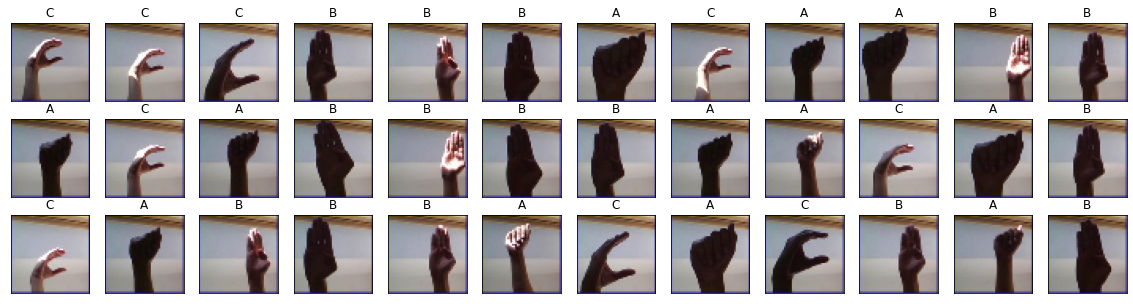

In [244]:
# Store labels of dataset
labels = ['A', 'B', 'C']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

## 3. Examine the dataset
<p>Let's examine how many images of each letter can be found in the dataset.</p>
<p>Remember that dataset has already been split into training and test sets for you, where <code>x_train</code> and <code>x_test</code> contain the images, and <code>y_train</code> and <code>y_test</code> contain their corresponding labels.</p>
<p>Each entry in <code>y_train</code> and <code>y_test</code> is one of <code>0</code>, <code>1</code>, or <code>2</code>, corresponding to the letters <code>'A'</code>, <code>'B'</code>, and <code>'C'</code>, respectively.</p>
<p>We will use the arrays <code>y_train</code> and <code>y_test</code> to verify that both the training and test sets each have roughly equal proportions of each letter.</p>

In [245]:
# Number of A's in the training dataset
num_A_train = sum(y_train==0)
# Number of B's in the training dataset
num_B_train = sum(y_train==1)
# Number of C's in the training dataset
num_C_train = sum(y_train==2)

# Number of A's in the test dataset
num_A_test = sum(y_test==0)
# Number of B's in the test dataset
num_B_test = sum(y_test==1)
# Number of C's in the test dataset
num_C_test = sum(y_test==2)

# Print statistics about the dataset
print("Training set:")
print("\tA: {}, B: {}, C: {}".format(num_A_train, num_B_train, num_C_train))
print("Test set:")
print("\tA: {}, B: {}, C: {}".format(num_A_test, num_B_test, num_C_test))

Training set:
	A: 547, B: 531, C: 522
Test set:
	A: 134, B: 126, C: 140


## 4. One-hot encode the data
<p>Currently, our labels for each of the letters are encoded as categorical integers, where <code>'A'</code>, <code>'B'</code> and <code>'C'</code> are encoded as <code>0</code>, <code>1</code>, and <code>2</code>, respectively.  However, recall that Keras models do not accept labels in this format, and we must first one-hot encode the labels before supplying them to a Keras model.</p>
<p>This conversion will turn the one-dimensional array of labels into a two-dimensional array.</p>
<p><img src="https://assets.datacamp.com/production/project_509/img/onehot.png" alt="one-hot encoding"></p>
<p>Each row in the two-dimensional array of one-hot encoded labels corresponds to a different image.  The row has a <code>1</code> in the column that corresponds to the correct label, and <code>0</code> elsewhere.  </p>
<p>For instance, </p>
<ul>
<li><code>0</code> is encoded as <code>[1, 0, 0]</code>, </li>
<li><code>1</code> is encoded as <code>[0, 1, 0]</code>, and </li>
<li><code>2</code> is encoded as <code>[0, 0, 1]</code>.</li>
</ul>

In [246]:
from keras.utils import np_utils

# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train)

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test)

## 5. Define the model
<p>Now it's time to define a convolutional neural network to classify the data.</p>
<p>This network accepts an image of an American Sign Language letter as input.  The output layer returns the network's predicted probabilities that the image belongs in each category.</p>

In [247]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=5, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(50, 50, 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# Summarize the model
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 50, 50, 5)         380       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 12, 12, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 12, 12, 15)        1890      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 3, 3, 15)         0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 135)               0         
                                                                 
 dense_30 (Dense)            (None, 3)               

## 6. Compile the model
<p>After we have defined a neural network in Keras, the next step is to compile it! </p>

In [248]:
# Compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## 7. Train the model
<p>Once we have compiled the model, we're ready to fit it to the training data.</p>

In [249]:
# Train the model
hist = model.fit(x_train, y_train_OH, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
40/40 [==============================] - 1s 24ms/step - loss: 0.9916 - accuracy: 0.5641 - val_loss: 0.7966 - val_accuracy: 0.7563
Epoch 2/2
40/40 [==============================] - 1s 21ms/step - loss: 0.6567 - accuracy: 0.7781 - val_loss: 0.5124 - val_accuracy: 0.8281


## 8. Test the model
<p>To evaluate the model, we'll use the test dataset.  This will tell us how the network performs when classifying images it has never seen before!</p>
<p>If the classification accuracy on the test dataset is similar to the training dataset, this is a good sign that the model did not overfit to the training data.  </p>

In [250]:
# Obtain accuracy on test set
score = model.evaluate(x=x_test, 
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.8475000262260437


## 9. Visualize mistakes
<p>Hooray!  Our network gets very high accuracy on the test set!  </p>
<p>The final step is to take a look at the images that were incorrectly classified by the model.  Do any of the mislabeled images look relatively difficult to classify, even to the human eye?  </p>
<p>Sometimes, it's possible to review the images to discover special characteristics that are confusing to the model.  However, it is also often the case that it's hard to interpret what the model had in mind!</p>

13/13 [==============================] - 0s 6ms/step


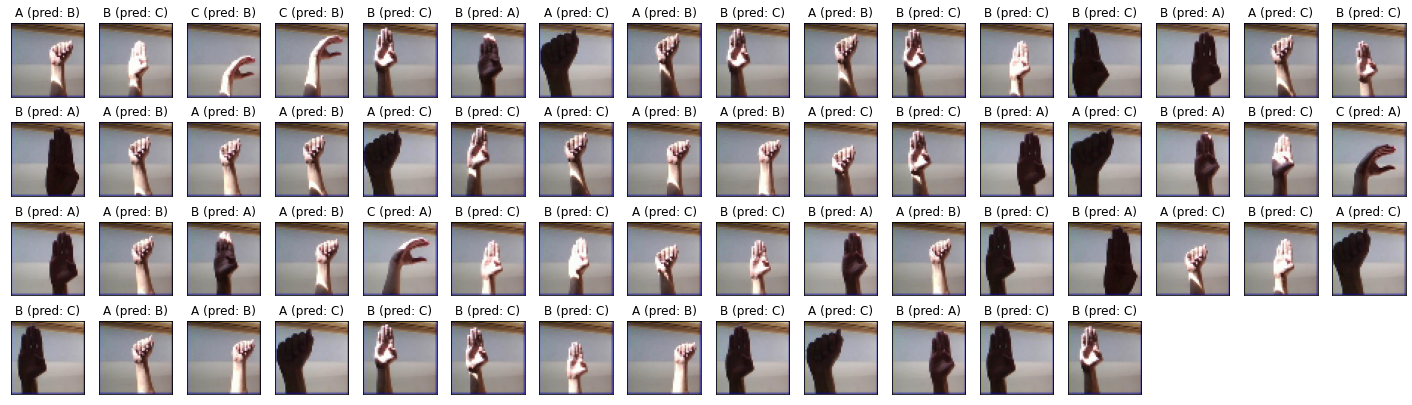

In [251]:
# Get predicted probabilities for test dataset
y_probs = model.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

# Print mislabeled examples
fig = plt.figure(figsize=(25,7))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(4, int(np.ceil(len(bad_test_idxs)/4)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

## 10. Extenstion of DataCamp Project
First to extend the DataCamp portion of the project we will analyze the mistakes of the model made and also retrain the original model over more epochs to achive a greater accuracy.

The cell below sorts through the incorrect predictions from the model above based on what their actual value was supposed to be.

In [252]:
list_a=[]
list_b=[]
list_c=[]

for i, idx in enumerate(bad_test_idxs):
    if labels[y_test[idx]] == 'A':
        list_a.append([labels[y_test[idx]], labels[y_preds[idx]]])
    if labels[y_test[idx]] == 'B':
        list_b.append([labels[y_test[idx]], labels[y_preds[idx]]])
    if labels[y_test[idx]] == 'C':
        list_c.append([labels[y_test[idx]], labels[y_preds[idx]]])


print("Number of A's incorrectly identified: ", len(list_a))
print("Number of B's incorrectly identified: ", len(list_b))
print("Number of C's incorrectly identified: ", len(list_c))

Number of A's incorrectly identified:  25
Number of B's incorrectly identified:  32
Number of C's incorrectly identified:  4


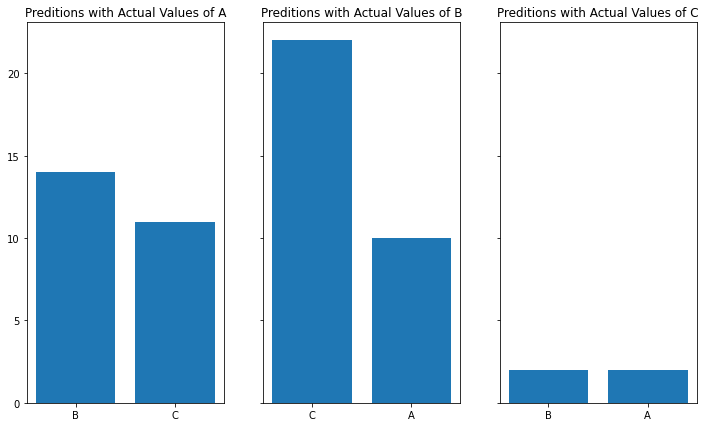

In [253]:
import pandas as pd
import matplotlib.pyplot as plt

df_a = pd.DataFrame(list_a, columns=['Actual', 'Predicted'])
df_b = pd.DataFrame(list_b, columns=['Actual', 'Predicted'])
df_c = pd.DataFrame(list_c, columns=['Actual', 'Predicted'])

A_count = pd.value_counts(df_a['Predicted'].values, sort=True)
B_count = pd.value_counts(df_b['Predicted'].values, sort=True)
C_count = pd.value_counts(df_c['Predicted'].values, sort=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,7), sharey=True)

ax1.bar(A_count.index, A_count)
ax2.bar(B_count.index, B_count)
ax3.bar(C_count.index, C_count)
ax1.title.set_text('Preditions with Actual Values of A')
ax2.title.set_text('Preditions with Actual Values of B')
ax3.title.set_text('Preditions with Actual Values of C')

When looking at the plots above we can see the model does the worst as classifying the letter B and when it makes a mistake it most commonly will calssify it as a C. We also can see that when the model makes mistakes on A predicts B slightly more often than C. It is also important to note that it makes the least amount of mistakes on C. Due to the nature of how deep learning models work it is difficult to know why the model is making these mistakes. One thing that is noticable to even just the human eye is how different the letter C is from A and B in ASL and also how A and B are somewhat similar. It's hard to know if this effects the model, but to move forward we will train the model over more epochs and see if the new model more is able to decrease on these mistakes.

We will now define the same model but train it for 5 epochs instead of two and see how it performs.

In [254]:
# Defining model
model2 = Sequential()
# First convolutional layer accepts image input
model2.add(Conv2D(filters=5, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(50, 50, 3)))
# Add a max pooling layer
model2.add(MaxPooling2D(pool_size=4))
# Add a convolutional layer
model2.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add another max pooling layer
model2.add(MaxPooling2D(pool_size=4))
# Flatten and feed to output layer
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))

# Summarize the model
model2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 50, 50, 5)         380       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 12, 12, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 12, 12, 15)        1890      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 3, 3, 15)         0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 135)               0         
                                                                 
 dense_31 (Dense)            (None, 3)               

Below we make a visualization of the model defined above.

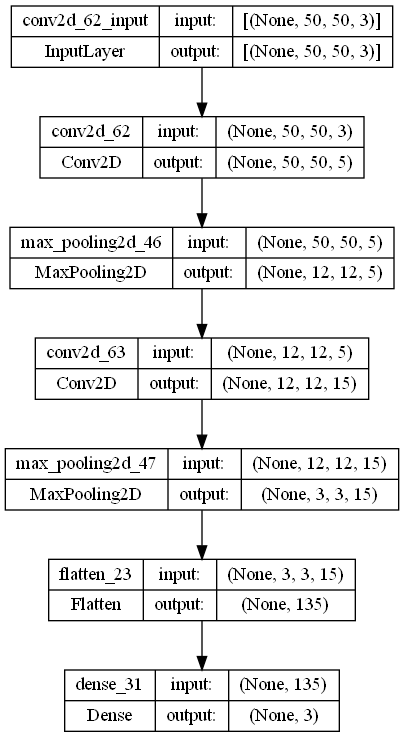

In [255]:
from keras.utils.vis_utils import plot_model
import pydot
import graphviz
import pydotplus

plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

Below we show how the training and validation accuracy change over each epoch as we fit the model. We can see that by 5 epochs it begins to level off to an validation accuracy of 98%. We see also see the loss function decrease as the model trains over 5 epochs.

In [256]:
import keras
from matplotlib import pyplot as plt

# Compile the model
model2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


hist2 = model2.fit(x_train, y_train_OH, epochs=5, batch_size=32, validation_split=0.2)
print('Final Validation Accuracy: ', hist2.history['val_accuracy'][-1])

Epoch 1/5
40/40 [==============================] - 2s 26ms/step - loss: 0.9877 - accuracy: 0.5680 - val_loss: 0.8713 - val_accuracy: 0.7906
Epoch 2/5
40/40 [==============================] - 1s 22ms/step - loss: 0.7174 - accuracy: 0.8359 - val_loss: 0.6027 - val_accuracy: 0.8687
Epoch 3/5
40/40 [==============================] - 1s 20ms/step - loss: 0.4687 - accuracy: 0.9102 - val_loss: 0.3946 - val_accuracy: 0.9000
Epoch 4/5
40/40 [==============================] - 1s 19ms/step - loss: 0.3055 - accuracy: 0.9359 - val_loss: 0.2769 - val_accuracy: 0.9219
Epoch 5/5
40/40 [==============================] - 1s 20ms/step - loss: 0.2111 - accuracy: 0.9680 - val_loss: 0.1769 - val_accuracy: 0.9844
Final Validation Accuracy:  0.984375


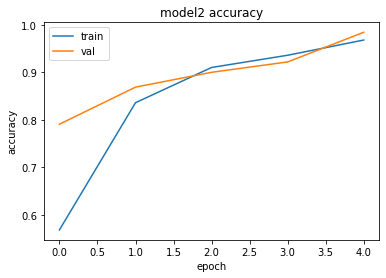

In [257]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

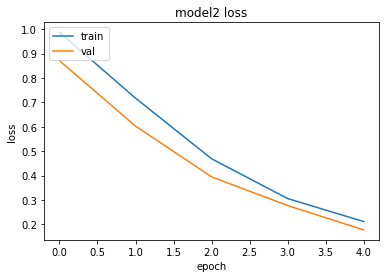

In [258]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Below we evaluate the model againt the test set and see that we get a 98% accuracy so it is unlikley that we are over or underfitting and likely have a good model.

In [259]:
score = model2.evaluate(x=x_test, 
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9850000143051147


Below we repeat what we did above looking at what the model did not do well. 

13/13 [==============================] - 0s 6ms/step


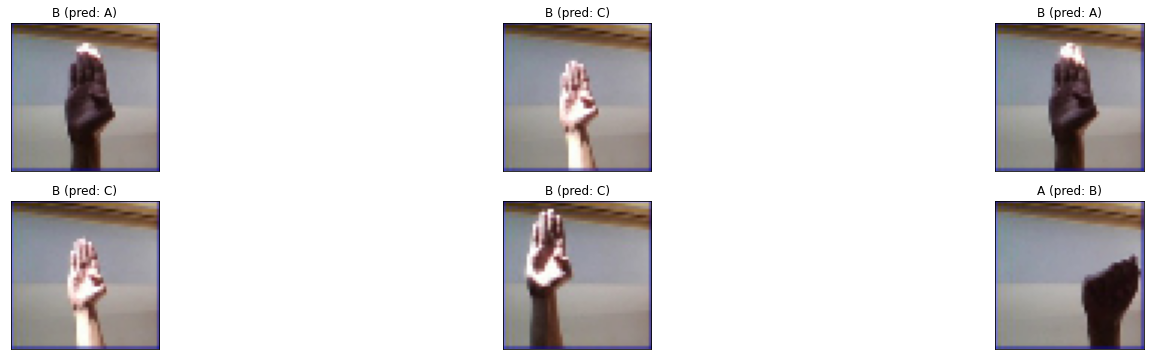

In [260]:
# Get predicted probabilities for test dataset
y_probs = model2.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

# Print mislabeled examples
fig = plt.figure(figsize=(25,6))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(2, int(np.ceil(len(bad_test_idxs)/2)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

We are able to see we make much less mistakes and even correctly identify all of the C's. This makes sense since training over more epochs increases the number of interations that the model is trained.

In [261]:
list_a=[]
list_b=[]
list_c=[]

for i, idx in enumerate(bad_test_idxs):
    if labels[y_test[idx]] == 'A':
        list_a.append([labels[y_test[idx]], labels[y_preds[idx]]])
    if labels[y_test[idx]] == 'B':
        list_b.append([labels[y_test[idx]], labels[y_preds[idx]]])
    if labels[y_test[idx]] == 'C':
        list_c.append([labels[y_test[idx]], labels[y_preds[idx]]])


print("Number of A's incorrectly identified: ", len(list_a))
print("Number of B's incorrectly identified: ", len(list_b))
print("Number of C's incorrectly identified: ", len(list_c))

Number of A's incorrectly identified:  1
Number of B's incorrectly identified:  5
Number of C's incorrectly identified:  0


Below we can see that the model still struggles the most to identify the letter B, mistaking it most often as a C like before. We also notice that it only makes one mistake on the ltter A, mistaking it for a B. 

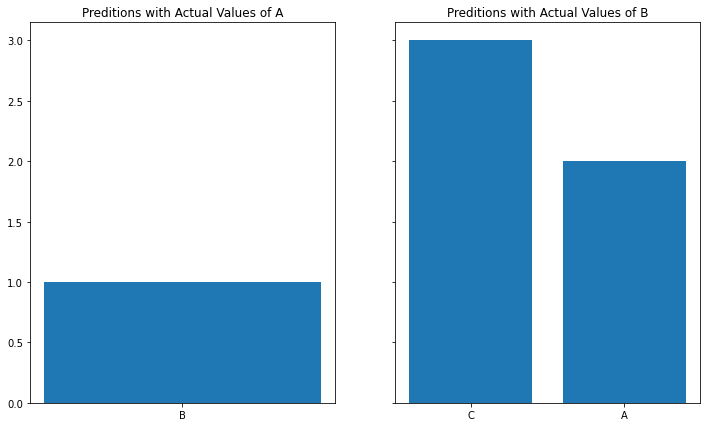

In [262]:
df_a = pd.DataFrame(list_a, columns=['Actual', 'Predicted'])
df_b = pd.DataFrame(list_b, columns=['Actual', 'Predicted'])
df_c = pd.DataFrame(list_c, columns=['Actual', 'Predicted'])

A_count = pd.value_counts(df_a['Predicted'].values, sort=True)
B_count = pd.value_counts(df_b['Predicted'].values, sort=True)
C_count = pd.value_counts(df_c['Predicted'].values, sort=True)

# plot(A_count, kind='barh', title='Actually A')
# B_count.plot(kind='barh', title='Actually B')
# C_count.plot(kind='barh', title='Actually C')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7), sharey=True)

ax1.bar(A_count.index, A_count)
ax2.bar(B_count.index, B_count)
ax1.title.set_text('Preditions with Actual Values of A')
ax2.title.set_text('Preditions with Actual Values of B')

## 11. Fitting Model on D, E, and F
Knowing what we know now about the importance of training a model over the appropriate amount of epochs. We will try and fit the same model for the next three letters in the alphabet D, E, and F to see if it is generalizable to different letters. The data for this can be found on kaggle at: https://www.kaggle.com/datasets/grassknoted/asl-alphabet

Below we follow the same steps as above when loading the data, visualizing the training data, hot encoding the labels, and creating a model.

In [263]:
(x_train, y_train), (x_test, y_test) = load_data(folders=['D', 'E', 'F'])

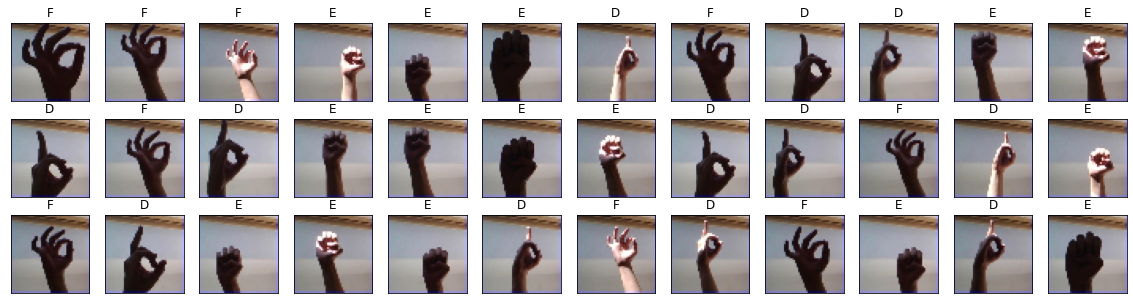

In [264]:
# Store labels of dataset
labels = ['D', 'E', 'F']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

In [265]:
# Number of D's in the training dataset
num_D_train = sum(y_train==0)
# Number of E's in the training dataset
num_E_train = sum(y_train==1)
# Number of F's in the training dataset
num_F_train = sum(y_train==2)

# Number of D's in the test dataset
num_D_test = sum(y_test==0)
# Number of E's in the test dataset
num_E_test = sum(y_test==1)
# Number of F's in the test dataset
num_F_test = sum(y_test==2)

# Print statistics about the dataset
print("Training set:")
print("\tD: {}, E: {}, F: {}".format(num_D_train, num_E_train, num_F_train))
print("Test set:")
print("\tD: {}, E: {}, F: {}".format(num_D_test, num_E_test, num_F_test))

Training set:
	D: 547, E: 531, F: 522
Test set:
	D: 134, E: 126, F: 140


In [266]:
from keras.utils import np_utils

# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train)

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test)

In [267]:
model3 = Sequential()
# First convolutional layer accepts image input
model3.add(Conv2D(filters=5, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(50, 50, 3)))
# Add a max pooling layer
model3.add(MaxPooling2D(pool_size=4))
# Add a convolutional layer
model3.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add another max pooling layer
model3.add(MaxPooling2D(pool_size=4))
# Flatten and feed to output layer
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))

# Summarize the model
model3.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 50, 50, 5)         380       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 12, 12, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 12, 12, 15)        1890      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 3, 3, 15)         0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 135)               0         
                                                                 
 dense_32 (Dense)            (None, 3)               

The visualization for this model is below.

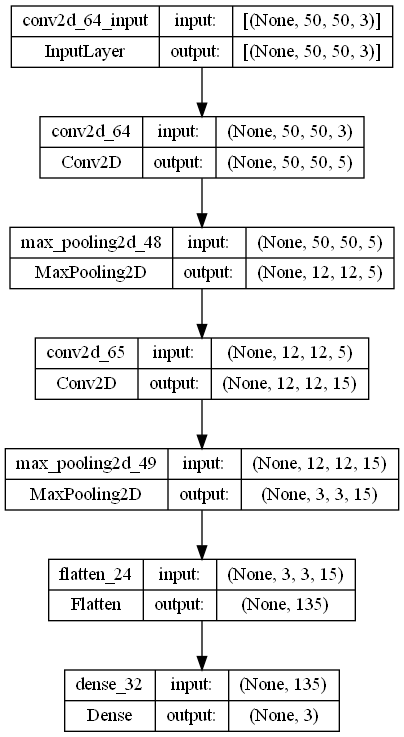

In [268]:
plot_model(model3, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

In [269]:
# Compile the model
model3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

When chosing the number of epochs to train on 5 was originally choosen but the accuracy was quite low so it was bumped up to 10 and a better accuracy was obtained.

In [270]:
# Train the model
hist3 = model3.fit(x_train, y_train_OH, epochs=10, batch_size=32, validation_split=0.2)
print('Final Validation Accuracy: ', hist3.history['val_accuracy'][-1])

Epoch 1/10
40/40 [==============================] - 1s 23ms/step - loss: 1.0047 - accuracy: 0.5641 - val_loss: 0.8496 - val_accuracy: 0.8219
Epoch 2/10
40/40 [==============================] - 1s 19ms/step - loss: 0.7714 - accuracy: 0.7422 - val_loss: 0.5976 - val_accuracy: 0.8344
Epoch 3/10
40/40 [==============================] - 1s 21ms/step - loss: 0.5741 - accuracy: 0.8180 - val_loss: 0.4467 - val_accuracy: 0.8969
Epoch 4/10
40/40 [==============================] - 1s 23ms/step - loss: 0.4398 - accuracy: 0.8586 - val_loss: 0.3519 - val_accuracy: 0.9094
Epoch 5/10
40/40 [==============================] - 1s 26ms/step - loss: 0.3518 - accuracy: 0.8914 - val_loss: 0.2693 - val_accuracy: 0.9375
Epoch 6/10
40/40 [==============================] - 1s 24ms/step - loss: 0.2763 - accuracy: 0.9297 - val_loss: 0.2613 - val_accuracy: 0.9312
Epoch 7/10
40/40 [==============================] - 1s 24ms/step - loss: 0.2123 - accuracy: 0.9516 - val_loss: 0.2420 - val_accuracy: 0.9250
Epoch 8/10
40

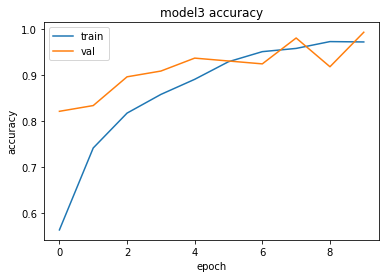

In [271]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('model3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

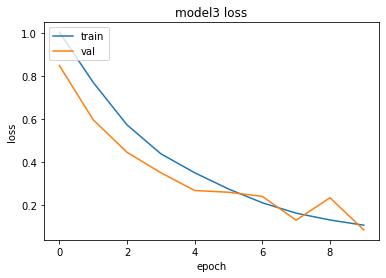

In [272]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The test accuracy is close to that of the validation accuracy so we should have a good model.

In [273]:
# Obtain accuracy on test set
score = model3.evaluate(x=x_test, 
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9950000047683716


Below we can see that the model only made mistakes on the letter D classifying them as an E in both cases.

13/13 [==============================] - 0s 9ms/step


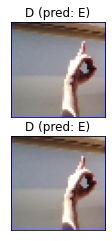

In [274]:
# Get predicted probabilities for test dataset
y_probs = model3.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

# Print mislabeled examples
fig = plt.figure(figsize=(25,8))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(4, int(np.ceil(len(bad_test_idxs)/4)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

## 12. Training Model for A-F

Above we saw how the less complx original model did a good job at classifying D, E, and F. Below a much more complex model will be created to indetify letters A, B, C, D, E, and F. The same steps in the above models are used here again.

In [275]:
(x_train, y_train), (x_test, y_test) = load_data(folders=['A', 'B', 'C', 'D', 'E', 'F'], size=4000)

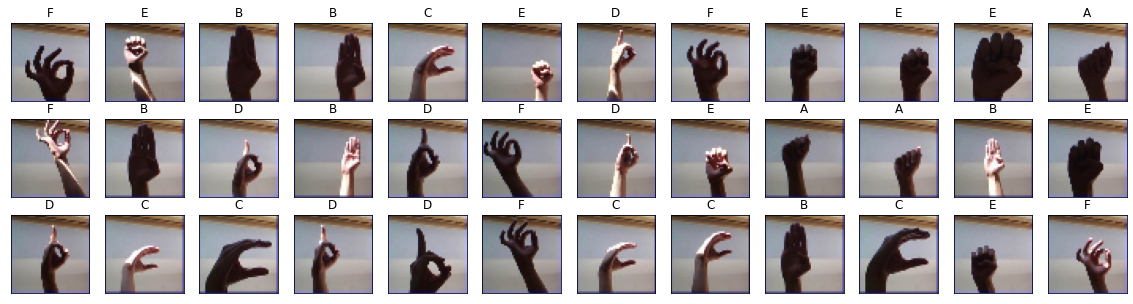

In [276]:
# Store labels of dataset
labels = ['A', 'B', 'C', 'D', 'E', 'F']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

In [277]:
# Number of A's in the training dataset
num_A_train = sum(y_train==0)
# Number of B's in the training dataset
num_B_train = sum(y_train==1)
# Number of C's in the training dataset
num_C_train = sum(y_train==2)
# Number of D's in the training dataset
num_D_train = sum(y_train==3)
# Number of E's in the training dataset
num_E_train = sum(y_train==4)
# Number of F's in the training dataset
num_F_train = sum(y_train==5)

# Number of A's in the test dataset
num_A_test = sum(y_test==0)
# Number of B's in the test dataset
num_B_test = sum(y_test==1)
# Number of C's in the test dataset
num_C_test = sum(y_test==2)
# Number of D's in the test dataset
num_D_test = sum(y_test==3)
# Number of E's in the test dataset
num_E_test = sum(y_test==4)
# Number of F's in the test dataset
num_F_test = sum(y_test==5)

# Print statistics about the dataset
print("Training set:")
print("\tA: {}, B: {}, C: {}, D: {}, E: {}, F: {}".format(num_A_train, num_B_train, num_C_train, num_D_train, num_E_train, num_F_train))
print("Test set:")
print("\tA: {}, B: {}, C: {}, D: {}, E: {}, F: {}".format(num_A_test, num_B_test, num_C_test, num_D_test, num_E_test, num_F_test))

Training set:
	A: 524, B: 554, C: 543, D: 534, E: 534, F: 511
Test set:
	A: 123, B: 132, C: 134, D: 125, E: 146, F: 140


In [278]:
# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train)

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test)

One very important thing to note is the difference in the number of trainable parameters in this model verus the model above. Above we had 2,678 trainable parameters and now have 197,304. This shows just how much more complex this model is compared to the previous models, which should hopefully lead to really good prediction accuracy.

In [279]:
from tensorflow.keras.layers import Dropout

model4 = keras.Sequential()
model4.add(Conv2D(filters=5, kernel_size=5, activation='relu',
        input_shape=(50, 50, 3)))
model4.add(Conv2D(15, 5, activation='relu'))
model4.add(MaxPooling2D(pool_size=2))
model4.add(Dropout(rate=0.25))
model4.add(Conv2D(30, 5, activation='relu'))
model4.add(Conv2D(60, 5, activation='relu'))
model4.add(MaxPooling2D(pool_size=2))
model4.add(Dropout(rate=0.25))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dropout(rate=0.25))
model4.add(Dense(6, activation='softmax'))
model4.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 46, 46, 5)         380       
                                                                 
 conv2d_67 (Conv2D)          (None, 42, 42, 15)        1890      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 21, 21, 15)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 21, 21, 15)        0         
                                                                 
 conv2d_68 (Conv2D)          (None, 17, 17, 30)        11280     
                                                                 
 conv2d_69 (Conv2D)          (None, 13, 13, 60)        45060     
                                                     

Below is a visualization of the model from above. It is very easy to see how this model is more complex than the models before it. It is a much more deep model as it adds more convolution layers, pooling layers, and also includes dropout layers to prevent overfitting.

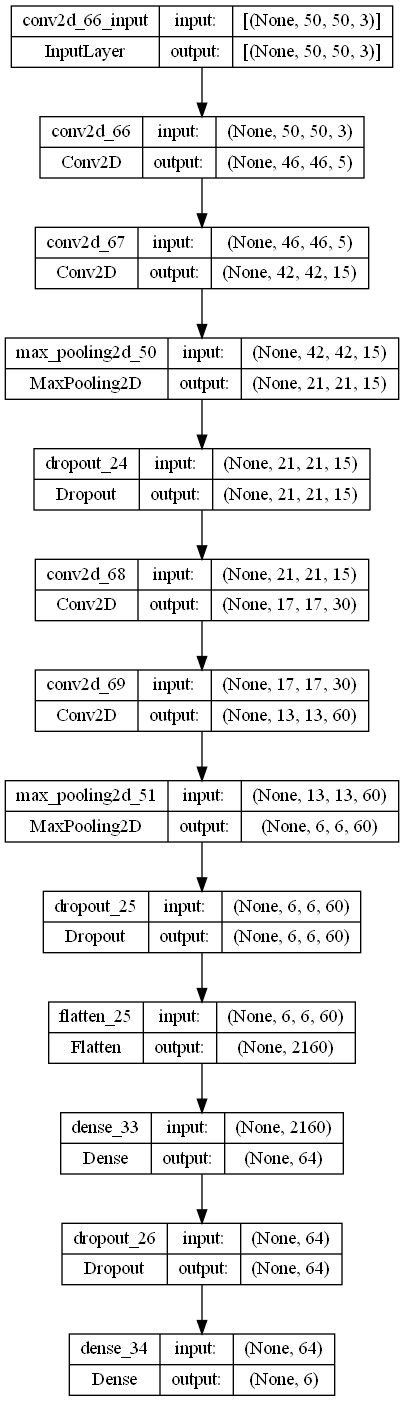

In [280]:
plot_model(model4, to_file='model4_plot.png', show_shapes=True, show_layer_names=True)

In [281]:
# Compile the model
model4.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
hist4 = model4.fit(x_train, y_train_OH, epochs=5, batch_size=32, validation_split=0.2)
print('Final Validation Accuracy: ', hist4.history['val_accuracy'][-1])

Epoch 1/5
80/80 [==============================] - 7s 80ms/step - loss: 1.4436 - accuracy: 0.4332 - val_loss: 0.8801 - val_accuracy: 0.7156
Epoch 2/5
80/80 [==============================] - 6s 78ms/step - loss: 0.5562 - accuracy: 0.8070 - val_loss: 0.2377 - val_accuracy: 0.9187
Epoch 3/5
80/80 [==============================] - 6s 73ms/step - loss: 0.2459 - accuracy: 0.9184 - val_loss: 0.0656 - val_accuracy: 0.9812
Epoch 4/5
80/80 [==============================] - 6s 75ms/step - loss: 0.1245 - accuracy: 0.9594 - val_loss: 0.0298 - val_accuracy: 0.9922
Epoch 5/5
80/80 [==============================] - 9s 116ms/step - loss: 0.1011 - accuracy: 0.9703 - val_loss: 0.0175 - val_accuracy: 0.9953
Final Validation Accuracy:  0.995312511920929


Below we can see the plots for the model accuracy and loss function.

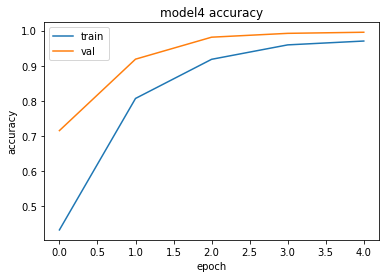

In [282]:
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('model4 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

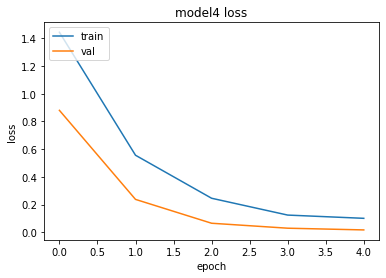

In [283]:
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Below we see that the test accuracy is 99% which is the same as the validation accuracy so it should be a good model.

In [284]:
# Obtain accuracy on test set
score = model4.evaluate(x=x_test, 
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9950000047683716


Below we show the one incorrect predictions. For the two mistakes with actual value B the model predicts E. The model also mistakes a F as a B and an E as an A.

25/25 [==============================] - 1s 22ms/step


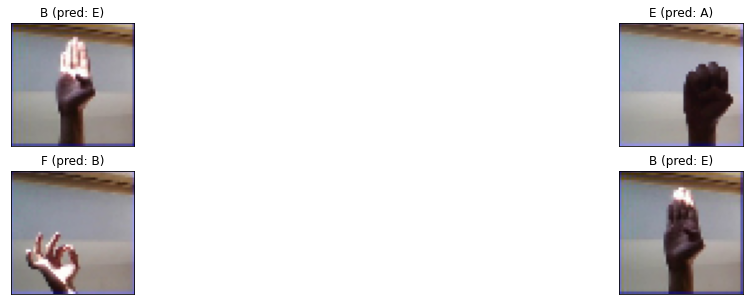

In [285]:
# Get predicted probabilities for test dataset
y_probs = model4.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

# Print mislabeled examples
fig = plt.figure(figsize=(20,5))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(2, int(np.ceil(len(bad_test_idxs)/2)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

## 11. Conclusion

In this project multiple models were created to predict various ASL letters to differing levels of accuracy. In it we were able to see the affect that increasing the number of epochs of training had on accuracy and also how important model complexity is on more complex data sets. Ultimately we created a model to make predictions for letters A through F that was much more complex than the orignal model in the DataCamp project. Based on the extreme accuracy the model was able to achieve on the test set, this model showed just how powerful a more complex model can be. That being said it puts into perspective just how complex very powerful deep learning models able to predict 1000s of different classifications truly are. 